# Modelo 1 - ML
### Security Data Science -- Laboratorio 3
#### Adrian Rodriguez 21619
#### Jose Daniel Gomez Cabrera 21429

In [161]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

Cargar el dataset

In [162]:
df = pd.read_csv('./data/MalBehavD-V1-dataset.csv')

## Modelo 1: Random Forest con TF-IDF

In [163]:
X_train_tfidf = np.load('./preprocessors/X_train_tfidf.npy')
X_test_tfidf = np.load('./preprocessors/X_test_tfidf.npy')
y_train = np.load('./preprocessors/y_train.npy')
y_test = np.load('./preprocessors/y_test.npy')

In [164]:
print(f"Dimensiones de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Dimensiones de X_test_tfidf: {X_test_tfidf.shape}")

Dimensiones de X_train_tfidf: (1799, 6754)
Dimensiones de X_test_tfidf: (771, 6754)


classifier de Random Forest

In [165]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

In [166]:
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_jobs=-1,
                       random_state=42)

In [167]:
y_pred = rf_classifier.predict(X_test_tfidf)
y_prob = rf_classifier.predict_proba(X_test_tfidf)[:, 1]

Evaluacion del rendimiento

In [168]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_prob)

In [169]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9468
Precision: 0.9886
Recall: 0.9039
F1 Score: 0.9444
ROC AUC: 0.9829


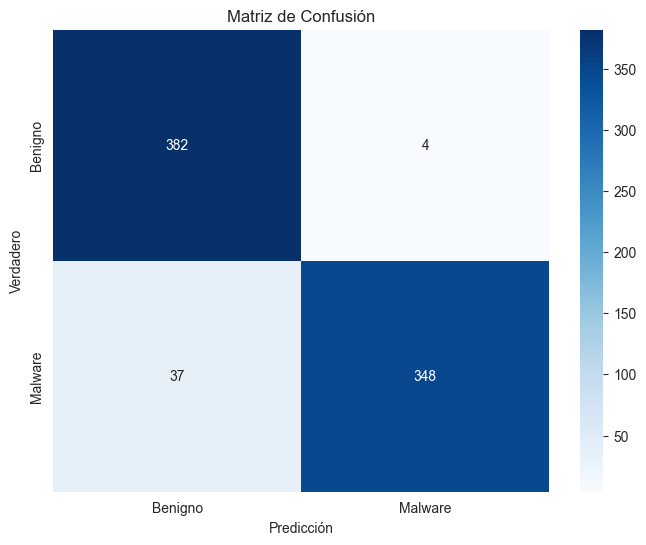

In [170]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno', 'Malware'],
            yticklabels=['Benigno', 'Malware'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.savefig('./model_results/confusion_matrix_model1.png')

Informe  de clasificacion

In [171]:
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Benigno', 'Malware']))


Informe de clasificación:
              precision    recall  f1-score   support

     Benigno       0.91      0.99      0.95       386
     Malware       0.99      0.90      0.94       385

    accuracy                           0.95       771
   macro avg       0.95      0.95      0.95       771
weighted avg       0.95      0.95      0.95       771



Curvas de ROC

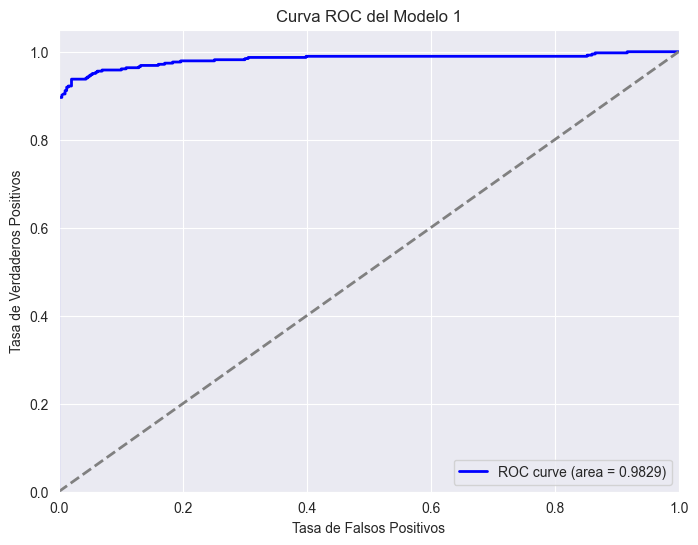

In [172]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Modelo 1')
plt.legend(loc='lower right')
plt.savefig('./model_results/roc_curve_model1.png')

Validación cruzada K = 10

In [173]:
print("\nRealizando validación cruzada (K=10)...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_accuracy = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='precision')
cv_recall = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='recall')
cv_f1 = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='f1')
cv_roc_auc = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='roc_auc')

print(f"CV Accuracy: {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f})")
print(f"CV Precision: {cv_precision.mean():.4f} (±{cv_precision.std():.4f})")
print(f"CV Recall: {cv_recall.mean():.4f} (±{cv_recall.std():.4f})")
print(f"CV F1 Score: {cv_f1.mean():.4f} (±{cv_f1.std():.4f})")
print(f"CV ROC AUC: {cv_roc_auc.mean():.4f} (±{cv_roc_auc.std():.4f})")


Realizando validación cruzada (K=10)...
CV Accuracy: 0.9355 (±0.0257)
CV Precision: 0.9839 (±0.0170)
CV Recall: 0.8856 (±0.0445)
CV F1 Score: 0.9317 (±0.0281)
CV ROC AUC: 0.9849 (±0.0092)


Curva de aprendizaje

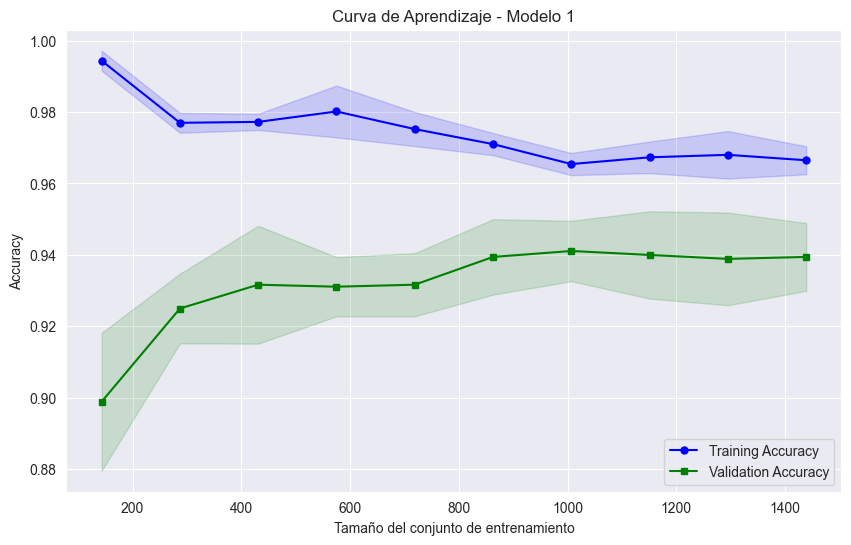

In [174]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X_train_tfidf, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Accuracy')
plt.title('Curva de Aprendizaje - Modelo 1')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('./model_results/learning_curve_model1.png')

Caracteristicas importantes del Modelo 1

In [175]:
if X_train_tfidf.shape[1] <= 100:  # Si hay demasiadas características, limitamos a las 100 más importantes
    importances = rf_classifier.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 características

    # Cargar el vectorizador para obtener los nombres de las características
    import pickle
    tfidf_vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))
    feature_names = tfidf_vectorizer.get_feature_names_out()

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('Top 20 características más importantes')
    plt.tight_layout()
    plt.savefig('./model_results/feature_importance_model1.png')

    print("\nTop 10 características más importantes:")
    for i in indices[-10:]:
        print(f"{feature_names[i]}: {importances[i]:.6f}")

Guardar modelo en un archivo pickle

In [176]:
pickle.dump(rf_classifier, open('./models/model1_rf_tfidf.pkl', 'wb'))